In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal
import numpy as np
import matplotlib.pyplot as plt
from mlagents_envs.environment import UnityEnvironment

In [2]:
if(torch.cuda.is_available()):
    device = torch.device("cuda")
    print(device, torch.cuda.get_device_name(0))
else:
    device= torch.device("cpu")
    print(device)

cuda GeForce GTX 1660 SUPER


In [3]:
# state = input of NN, action = output of NN
N_STATES  = 8
N_ACTIONS =2

In [4]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0., std=0.1)
        nn.init.constant_(m.bias, 0.1)

In [5]:
class Net(nn.Module):
    def __init__(self, ):
        super(Net, self).__init__()
        
        self.actor = nn.Sequential(
            nn.Linear(N_STATES, 128),
            nn.LayerNorm(128),
            nn.Linear(128, 128),
            nn.LayerNorm(128),
            nn.Linear(128, N_ACTIONS)
        )
        self.log_std = nn.Parameter(torch.ones(1, N_ACTIONS) * 0.0)
        self.apply(init_weights)
    
    def forward(self, x):
        mu    = self.actor(x)
        std   = self.log_std.exp().expand_as(mu)
        dist  = Normal(mu, std)
        return dist

In [6]:
net = Net().to(device)

In [7]:
optimizer = optim.Adam(net.parameters(), lr=0.001)

### Let NN interact with 3D ball to collect 20 steps of (s, a, r, s1) data from all agents

In [22]:
env = UnityEnvironment(file_name= None, base_port=5004)

In [23]:
env.reset()
behaviorNames = list(env.behavior_specs.keys())
behaviorName = behaviorNames[0]
print(behaviorName)

3DBall?team=0


In [24]:
NoAgents = 3 #My Unity scene has three training environment
NoSteps = 20

In [25]:
# collect (s,a,r,s1) from 20 good interactions with Unity
a = torch.FloatTensor([[0]]*NoAgents) #create NoAgents by 1 tensor
b = torch.FloatTensor([[0]*N_ACTIONS]*NoAgents) 
c = torch.FloatTensor([[0]*N_STATES]*NoAgents) 
values = rewards = masks = [a]*NoSteps
log_probs = actions = [b]*NoSteps
states =[c]*NoSteps

step = 0  #index 0
DecisionSteps, TerminalSteps = env.get_steps(behaviorName)
while(step < NoSteps): #try to run 20 good steps
    if(len(DecisionSteps) == 0): #we have no decision agents
        print("step ", step, "has no decision agents !")
        print("Decisin agents", list(DecisionSteps.agent_id))
        print("Terminal agents", list(TerminalSteps.agent_id))
        print("Reset the training environment!")
        env.reset() 
        DecisionSteps, TerminalSteps = env.get_steps(behaviorName)
        #continue next while loop without increase step
    else:  # we have decision agents
        lst = list(DecisionSteps.agent_id) + list(TerminalSteps.agent_id)
        if(len(list(set(lst))) != NoAgents): 
            #if this step misses some agents, then only interacts with Unity 
            #but do not collect data
            s = DecisionSteps.obs[0]  
            s = torch.FloatTensor(s).to(device)    
            dist = net(s)
            a = dist.sample() 
            env.set_actions(behaviorName, a.cpu().detach().numpy() )   
            env.step()
            DecisionSteps, TerminalSteps = env.get_steps(behaviorName)
            #continue next while loop without increase step
        else: 
            #this step includes all agents, collect (s, a, r, s1)
            s = DecisionSteps.obs[0]  
            s = torch.FloatTensor(s).to(device)         
            dist = net(s)
            a = dist.sample()
            log_prob = dist.log_prob(a)
            for idx in range(len(DecisionSteps)):
                #find decision agents and record their state, value and actions
                AgentID = DecisionSteps.agent_id[idx]
                states[step][AgentID]=s[idx]
                values[step][AgentID]= 0.2 # value will be estimated by critic NN later 
                actions[step][AgentID]=a[idx]
                log_probs[step][AgentID]=log_prob[idx]
            env.set_actions(behaviorName, a.cpu().detach().numpy() )   
            env.step()
            DecisionSteps, TerminalSteps = env.get_steps(behaviorName)
            #if next step misses some agents, then do not update step
            lst = list(DecisionSteps.agent_id) + list(TerminalSteps.agent_id)
            if(len(list(set(lst))) != NoAgents):
                continue #skip this step, run next while loop without increase step index
            else:
                #collect reward of this action from next decision and terminal steps
                if(len(TerminalSteps) >0):
                    #if next step has terminal agents, then collect terminal agents first
                    r = TerminalSteps.reward
                    r = torch.FloatTensor(r).unsqueeze(1)
                    for idx in range(len(TerminalSteps)):
                        AgentID = TerminalSteps.agent_id[idx]
                        rewards[step][AgentID]=r[idx]
                        masks[step][AgentID]= 0
                #collect from decision steps
                r = DecisionSteps.reward 
                r = torch.FloatTensor(r).unsqueeze(1)
                for idx in range(len(DecisionSteps)):
                    AgentID = DecisionSteps.agent_id[idx] 
                    if(rewards[step][AgentID] == None): #this agent is not in terminal step
                        rewards[step][AgentID]= r[idx]
                        masks[step][AgentID]= 1
                step = step + 1 #increase step and run next while

step  16 has no decision agents !
Decisin agents []
Terminal agents [1]
Reset the training environment!


In [26]:
env.close()

In [27]:
print(len(log_probs), log_probs[0].shape)
print(len(values), values[0].shape)
print(len(rewards), rewards[0].shape)
print(len(masks), masks[0].shape)
print(len(states), states[0].shape)
print(len(actions), actions[0].shape)

20 torch.Size([3, 2])
20 torch.Size([3, 1])
20 torch.Size([3, 1])
20 torch.Size([3, 1])
20 torch.Size([3, 8])
20 torch.Size([3, 2])


In [28]:
# we need to know the value of step 21
next_v = torch.FloatTensor([[0.2]]*NoAgents) 
values1 = values + [next_v]

### Calculate GAE of this training loop

In [29]:
gae = 0
gamma=0.99
tau=0.95
returns = []
for step in reversed(range(NoSteps)):
    delta = rewards[step] + gamma * values1[step + 1] * masks[step] - values1[step]
    gae = delta + gamma * tau * masks[step] * gae
    returns.insert(0, gae + values1[step])

In [30]:
print(len(returns), returns[0].shape)

20 torch.Size([3, 1])


### Use PPO to update NN weights and biases

In [31]:
returns   = torch.cat(returns).detach()
log_probs = torch.cat(log_probs).detach()
values    = torch.cat(values).detach()
states    = torch.cat(states) 
actions   = torch.cat(actions)
advantage = returns - values

In [32]:
print(len(returns), returns[0].shape)
print(len(log_probs), log_probs[0].shape)
print(len(values), values[0].shape)
print(len(states), states[0].shape)
print(len(actions), actions[0].shape)
print(len(advantage), advantage[0].shape)

60 torch.Size([1])
60 torch.Size([2])
60 torch.Size([1])
60 torch.Size([8])
60 torch.Size([2])
60 torch.Size([1])


randomly select batches of training data

In [33]:
states.shape

torch.Size([60, 8])

In [34]:
states.size(0)

60

In [35]:
batch_size = states.size(0)
mini_batch_size  = 5

In [36]:
batch_size // mini_batch_size

12

In [37]:
#from [0, batch_size], randomly select mini_batch_size
np.random.randint(0, batch_size, mini_batch_size)

array([22, 54, 38, 39, 51])

In [38]:
batch_size = states.size(0)
for _ in range(batch_size // mini_batch_size):
    rand_ids = np.random.randint(0, batch_size, mini_batch_size)
    break
print(rand_ids)
print(states[rand_ids, :].shape)
print(actions[rand_ids, :].shape) 
print(log_probs[rand_ids, :].shape) 
print(returns[rand_ids, :].shape)
print(advantage[rand_ids, :].shape)

[39 52 11  8 45]
torch.Size([5, 8])
torch.Size([5, 2])
torch.Size([5, 2])
torch.Size([5, 1])
torch.Size([5, 1])


In [39]:
def ppo_iter(mini_batch_size, states, actions, log_probs, returns, advantage):
    batch_size = states.size(0)
    for _ in range(batch_size // mini_batch_size):
        rand_ids = np.random.randint(0, batch_size, mini_batch_size)
        yield states[rand_ids, :], actions[rand_ids, :], log_probs[rand_ids, :], returns[rand_ids, :], advantage[rand_ids, :]

select one batch and perform PPO optimization

In [40]:
for batch_state, batch_action, batch_old_log_probs, batch_return, batch_advantage in ppo_iter(mini_batch_size, states, actions, log_probs, returns, advantage):
    break

In [41]:
print(batch_state.shape, batch_action.shape)

torch.Size([5, 8]) torch.Size([5, 2])


In [42]:
dist = net(batch_state.to(device))
print(dist)

Normal(loc: torch.Size([5, 2]), scale: torch.Size([5, 2]))


In [43]:
batch_action = dist.sample()
batch_new_log_probs = dist.log_prob(batch_action)
print(batch_new_log_probs.shape)

torch.Size([5, 2])


In [44]:
ratio = (batch_new_log_probs - batch_old_log_probs.to(device)).exp()
print(ratio)

tensor([[1.2427, 0.6327],
        [0.4962, 1.2191],
        [0.8360, 1.0056],
        [1.4339, 0.3089],
        [1.3568, 0.3191]], device='cuda:0', grad_fn=<ExpBackward>)


In [45]:
surr1 = ratio * batch_advantage.to(device)
print(surr1)

tensor([[0.0606, 0.0309],
        [0.0242, 0.0595],
        [0.0408, 0.0491],
        [0.0699, 0.0151],
        [0.0662, 0.0156]], device='cuda:0', grad_fn=<MulBackward0>)


In [46]:
clip_param=0.2
surr2 = torch.clamp(ratio, 1.0 - clip_param, 1.0 + clip_param) * batch_advantage.to(device)
print(surr2)

tensor([[0.0585, 0.0390],
        [0.0390, 0.0585],
        [0.0408, 0.0491],
        [0.0585, 0.0390],
        [0.0585, 0.0390]], device='cuda:0', grad_fn=<MulBackward0>)


In [47]:
actor_loss  = - torch.min(surr1, surr2).mean()
print(actor_loss)

tensor(-0.0410, device='cuda:0', grad_fn=<NegBackward>)


In [48]:
optimizer.zero_grad()
actor_loss.backward()
optimizer.step()

### run PPO optimization multiple epochs

In [49]:
ppo_epochs = 50
clip_param=0.2

In [50]:
lossLst = []
for _ in range(ppo_epochs):
    for batch_state, batch_action, batch_old_log_probs, batch_return, batch_advantage in ppo_iter(mini_batch_size, states, actions, log_probs, returns, advantage):
        dist = net(batch_state.to(device))
        batch_action = dist.sample()
        batch_new_log_probs = dist.log_prob(batch_action)
        ratio = (batch_new_log_probs - batch_old_log_probs.to(device)).exp()
        surr1 = ratio * batch_advantage.to(device)
        surr2 = torch.clamp(ratio, 1.0 - clip_param, 1.0 + clip_param) * batch_advantage.to(device)
        actor_loss  = - torch.min(surr1, surr2).mean()
        lossLst.append(float(actor_loss))
        optimizer.zero_grad()
        actor_loss.backward()
        optimizer.step()

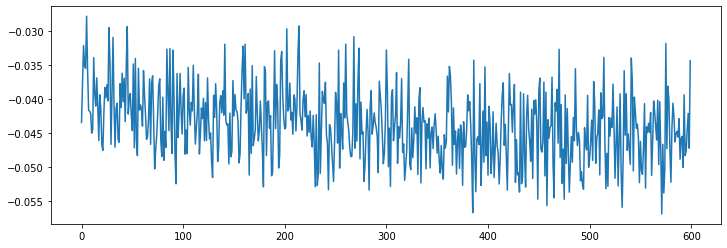

In [51]:
plt.figure(figsize=(12, 4))
plt.plot(lossLst)
plt.show()